In [2]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams.update(rcParams)

In [3]:
%%bash
cd .. && make clean && make

In file included from src/Exercice5_students.cpp:7:
src/ConfigFile.tpp:67:8: warning: variable 'out' is used uninitialized whenever 'if' condition is false [-Wsometimes-uninitialized]
   67 |   if ( val != configMap.end() ) {
      |        ^~~~~~~~~~~~~~~~~~~~~~
src/Exercice5_students.cpp:160:33: note: in instantiation of function template specialization 'ConfigFile::get<double>' requested here
  160 |         const double tfin = configFile.get<double>("tfin");
      |                                        ^
src/ConfigFile.tpp:74:10: note: uninitialized use occurs here
   74 |   return out;
      |          ^~~
src/ConfigFile.tpp:67:3: note: remove the 'if' if its condition is always true
   67 |   if ( val != configMap.end() ) {
      |   ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   68 |     std::istringstream iss(val->second);
   69 |     iss >> out;
   70 |     std::cout << "\t" << key << "=" << out << std::endl;
   71 |   }else{
      |    ~~~~~
   72 |     std::cerr << "[ConfigFile] Le para

In [4]:
config_name = 'corail2'
conf = load_conf(config_name)

In [5]:
# params, data_x, data_v, data_f
dataset = run_with_params(
    config_name,
    gen_variations({
        'xa': np.geomspace(conf['xa'], conf['xb']-20000, 4, endpoint=True, dtype=int),
    })
)

[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"
[ConfigFile] Ligne sans '=' : "# Physique :"


Running simulations... Done 4/4


# Plots!

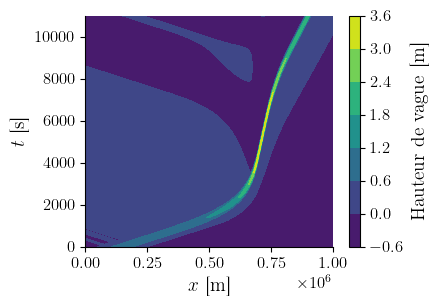

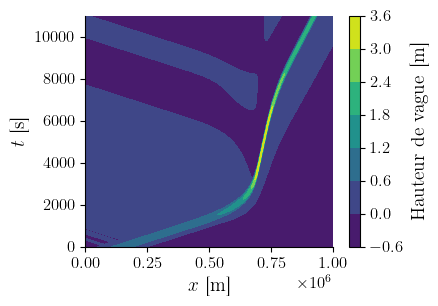

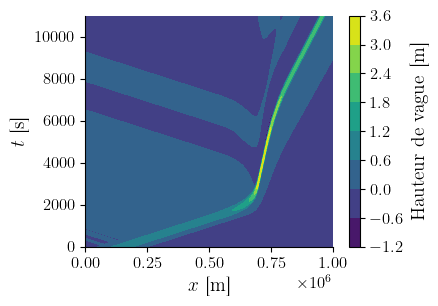

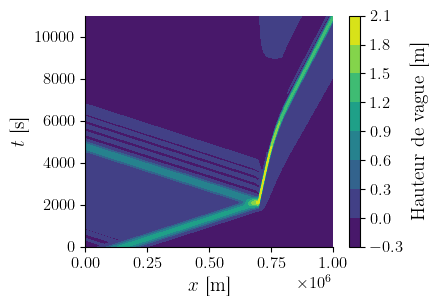

In [6]:
%matplotlib inline

for params, x, vitesse, f, h0 in dataset:
    X, Y = np.meshgrid(x, f[:,0])
    plt.contourf(X, Y, f[:,1:], cmap=plt.get_cmap('viridis'))
    plt.colorbar().set_label('Hauteur de vague [m]')
    plt.xlabel(r'$x$ [m]')
    plt.ylabel(r'$t$ [s]')
    plt.show()

# plt.savefig(export_path + 'corail_vague.pdf')

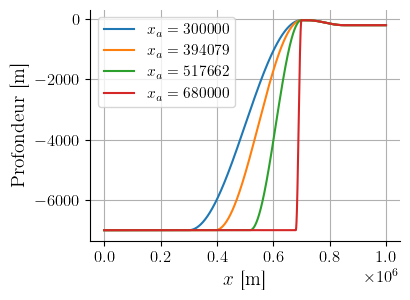

In [7]:
for params, x, vitesse, f, h0 in dataset:
    plt.plot(x, -h0, label=f'$x_a={params['xa']:.0f}$')
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'Profondeur [m]')
plt.legend()
plt.grid()

In [8]:
# Do your stuff here pwease
%matplotlib qt
import matplotlib.animation as mpla

plt.figure(figsize=(8, 8))

params, x, vitesse, f, h0 = dataset[-1]
plt.fill_between(x, -h0, -conf['hL'], color='xkcd:sand')
line, = plt.plot(x, f[0,1:], 'x-', markersize=5)
size = f.shape[0]

def animate(i) -> Any:
    idx = i % size
    line.set_data(x, f[idx,1:])


anim = mpla.FuncAnimation(plt.gcf(), animate, interval=20, cache_frame_data=True, frames=size)

plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y$ [m]')
plt.ylim(-3, 3)
plt.grid()
plt.show()
# anim.save('yeet.gif')

In [9]:
# Do your stuff here pwease
%matplotlib qt
from ipywidgets import interactive

fig = plt.figure(figsize=(8, 8))

params, x, vitesse, f, h0 = dataset[-1]
plt.fill_between(x, -h0, -conf['hL'], color='xkcd:sand')
size = f.shape[0]
print(f[len(f)-1,0])
def update(t = 0) -> Any:
    with mpl.rc_context({'text.usetex': False}):
        plt.gca().clear()
        plt.plot(x, f[t,1:], 'x-', markersize=5)
        idx_x_max = np.argmax(f[t,1:])
        plt.axvline(x[idx_x_max])
        plt.text(0.2, 2.5, f'h={f[t,idx_x_max+1]}')
        plt.xlabel(r'$x$ [m]')
        plt.ylabel(r'$y$ [m]')
        plt.ylim(-3, 3)
        plt.grid()
        plt.show()

interactive_plot = interactive(update, t=(0,f.shape[0]-1,1))
interactive_plot

11000.0862795444


interactive(children=(IntSlider(value=0, description='t', max=1181), Output()), _dom_classes=('widget-interact…

In [10]:
plt.close()

In [11]:
%matplotlib inline
actual_t = [None for _ in range(len(dataset))]
amplitudes = [None for _ in range(len(dataset))]
idx_x_max = [None for _ in range(len(dataset))]
sel_x = [None for _ in range(len(dataset))]
for idx, (params, x, vitesse, f, h0) in enumerate(dataset):
    h = f[:,1:]
    t = f[:,0]
    idx_x_max[idx] = np.argmax(h, axis=1)
    sel_x[idx] = x[idx_x_max[idx]]

    actual_t[idx] = np.copy(t)
    amplitudes[idx] = np.zeros(len(t))
    k = 3
    for i in range(len(t)):
        coefs = np.polyfit(t[max(0,i-k):i+k+1], h[max(0,i-k):i+k+1, idx_x_max[idx][i]], 2)
        fitfunc = np.poly1d(coefs)
        res = sc.optimize.minimize(lambda t: -fitfunc(t), 0, options={'disp': False})
        actual_t[idx][i] = res.x[0]
        amplitudes[idx][i] = -res.fun
    # amplitudes[idx][0] = amplitudes[idx][1]
    # amplitudes[idx][-1] = amplitudes[idx][-2]

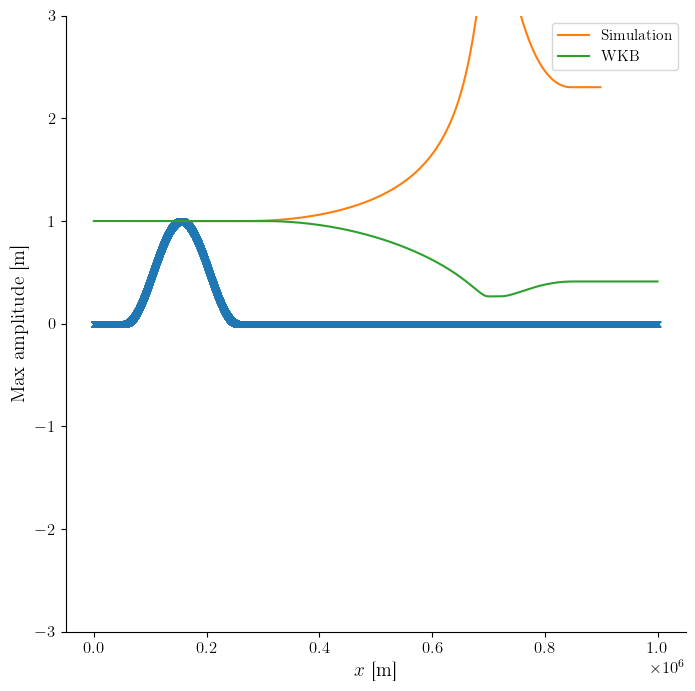

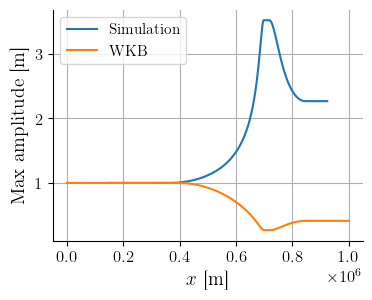

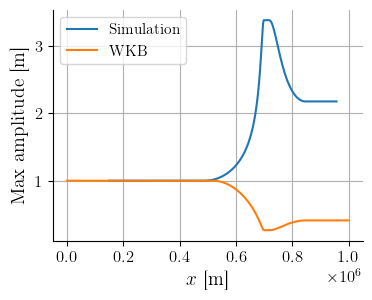

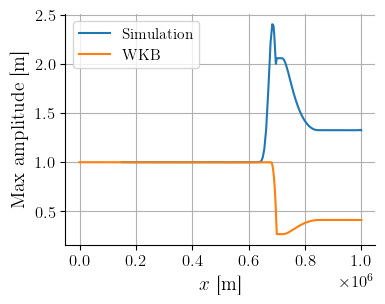

In [12]:
%matplotlib inline
for idx, (params, x, vitesse, f, h0) in enumerate(dataset):
    plt.plot(sel_x[idx], amplitudes[idx], label='Simulation')
    # plt.plot(sel_x[idx], f[:,1:].flatten()[np.arange(len(f)) * (f.shape[1]-1) + idx_x_max[idx]], label='Rough')
    # plt.scatter(sel_x[idx], amplitudes[idx], c=np.arange(len(sel_x[idx])), cmap='viridis', label='Simulation')
    plt.plot(x, (h0 * conf['A']/conf['hL'])**(1/4), label='WKB')
    plt.xlabel(r'$x$ [m]')
    plt.ylabel(r'Max amplitude [m]')
    plt.legend()
    plt.grid()
    plt.show()

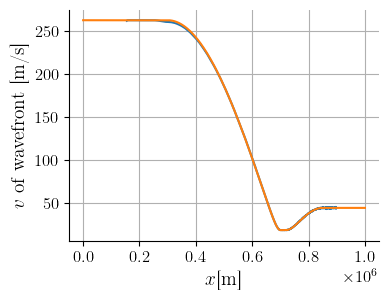

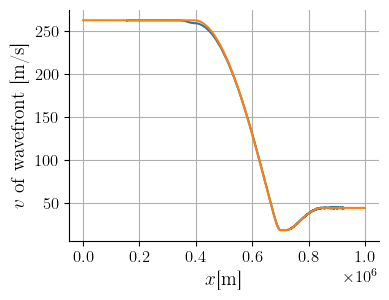

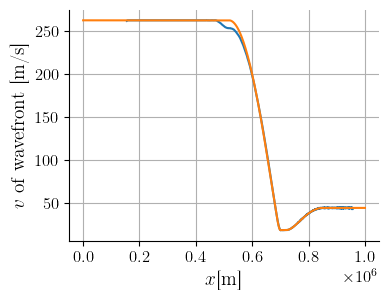

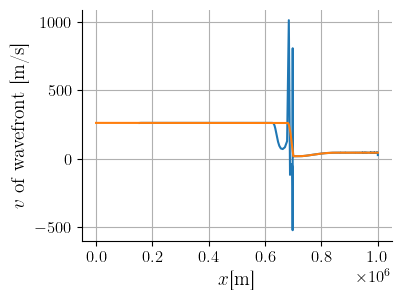

In [13]:
for idx, (params, x, vitesse, f, h0) in enumerate(dataset):
    k = 2
    vcalc = (sel_x[idx][2*k:] - sel_x[idx][:-2*k]) / (actual_t[idx][2*k:] - actual_t[idx][:-2*k])
    plt.plot(x[idx_x_max[idx]][k:-k], vcalc)
    vth = np.sqrt(9.81 * h0)
    plt.plot(x, vth, label='WKB')
    plt.xlabel(r'$x$[m]')
    plt.ylabel(r'$v$ of wavefront [m/s]')
    plt.grid()
    plt.show()

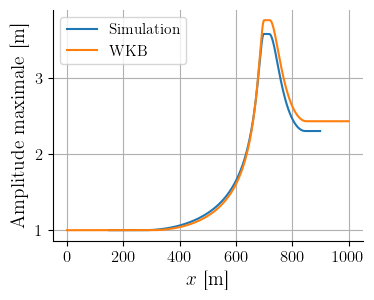

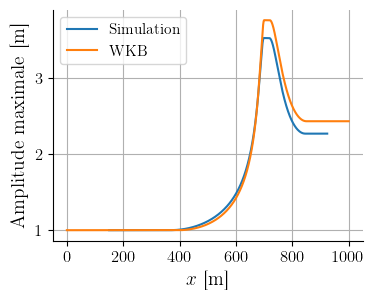

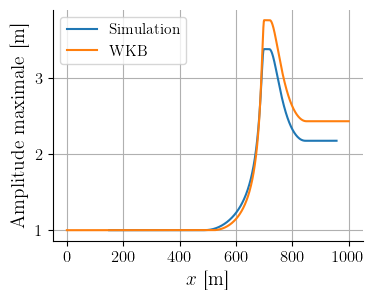

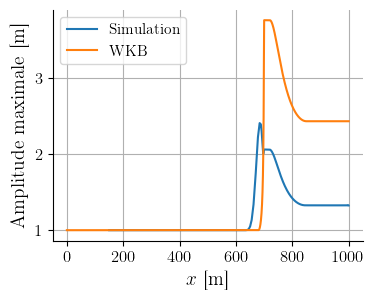

In [14]:
for idx, (params, x, vitesse, f, h0) in enumerate(dataset):
    plt.plot(x[idx_x_max[idx]]/1e3, amplitudes[idx], label='Simulation')
    plt.plot(x/1e3, conf['A'] * (h0/conf['hL'])**(-1/4), label='WKB')
    plt.xlabel(r'$x$ [m]')
    plt.ylabel(r'Amplitude maximale [m]')
    plt.legend()
    plt.grid()
    plt.show()